## Assignment: $k$ Means Clustering

## **Do two questions.**

`! git clone https://www.github.com/DS3001/kmc`

In [1]:
! git clone https://www.github.com/DS3001/kmc

Cloning into 'kmc'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 25 (delta 4), reused 3 (delta 3), pack-reused 18
Receiving objects: 100% (25/25), 5.04 MiB | 26.76 MiB/s, done.
Resolving deltas: 100% (4/4), done.


**Q1.** This question is a case study for $k$ means clustering.

1. Load the `airbnb_hw.csv` data. Clean `Price` along with `Beds`, `Number of Reviews`, and `Review Scores Rating`.
2. Maxmin normalize the data and remove any `nan`'s (`KMeans` from `sklearn` doesn't accept `nan` input).
3. Use `sklearn`'s `KMeans` module to cluster the data by `Beds`, `Number of Reviews`, and `Review Scores Rating` for `k=6`.
4. Use `seaborn`'s `.pairplot()` to make a grid of scatterplots that show how the clustering is carried out in multiple dimensions.
5. Use `.groupby` and `.describe` to compute the average price for each cluster. Which clusters have the highest rental prices?
6. Use a scree plot to pick the number of clusters and repeat steps 4 and 5.

In [2]:
import pandas as pd
import numpy as np
df = pd.read_csv("/content/kmc/data/airbnb_hw.csv")
df.head()
df.dtypes


df1 = df.copy()

df1 = df1.loc[:,["Price","Beds","Number Of Reviews","Review Scores Rating (bin)"]]
df1.head()

df1 = df1.rename(columns={"Number Of Reviews":"ReviewCounts","Review Scores Rating (bin)":"ReviewScores"})
df1.head()

df1.dtypes
df1["Price"].unique()
df1["Price"] = df1["Price"].str.replace(",","")
df1["Price"] = pd.to_numeric(df1["Price"],errors='coerce')
df1.dtypes

df1.Price.isna().sum()
df1.Beds.isna().sum()
df1.ReviewCounts.isna().sum()
df1.ReviewScores.isna().sum()
df1.describe()
df1.shape
df1 = df1.dropna()
df1.shape

df1.describe()
#

,Price,Beds,ReviewCounts,ReviewScores
count,22111.000000,22111.000000,22111.000000,22111.000000
mean,154.798697,1.558093,16.523179,90.736737
std,148.901275,1.044014,24.322185,9.061198
min,10.000000,0.000000,1.000000,20.000000
25%,85.000000,1.000000,3.000000,85.000000
50%,125.000000,1.000000,7.000000,90.000000
75%,190.000000,2.000000,20.000000,100.000000
max,10000.000000,16.000000,257.000000,100.000000


In [3]:

def maxmin(z):
    z = (z-min(z))/(max(z)-min(z))
    return(z)

X = df1.drop("Price",axis =1)
X = X.apply(maxmin)

In [4]:
from sklearn.cluster import KMeans

model = KMeans(n_clusters=6, max_iter=300, n_init = 10,  random_state=0)
model = model.fit(X)
X['cluster'] = model.labels_ # copied from solution

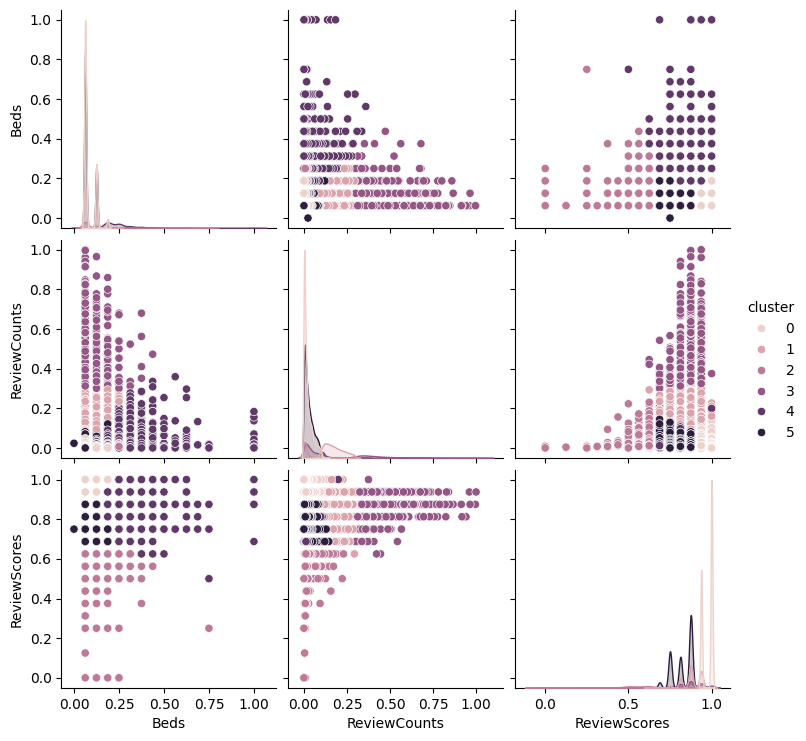

In [5]:
import seaborn as sns
sns.pairplot(X,hue="cluster")

In [6]:
X.describe()
df1["cluster"] = model.labels_
df1.loc[:,['Price','cluster'] ].groupby('cluster').describe()


Price                                                            
          count        mean         std   min    25%    50%    75%      max
cluster                                                                    
0        8430.0  154.484935  158.483673  10.0   85.0  130.0  195.0  10000.0
1        2954.0  142.079215   84.303713  22.0   88.0  125.0  175.0   1000.0
2         771.0  133.084306  199.549289  25.0   65.0   99.0  150.0   5000.0
3         775.0  133.110968   83.573023  27.0   80.0  109.0  165.0    875.0
4        1684.0  291.995249  259.957495  27.0  150.0  225.0  350.0   4500.0
5        7497.0  133.820862   97.671697  20.0   79.0  119.0  170.0   5000.0

Q1.5) Cluster 4 has the higest rental price with the mean rental price being around 292 dollars a night.

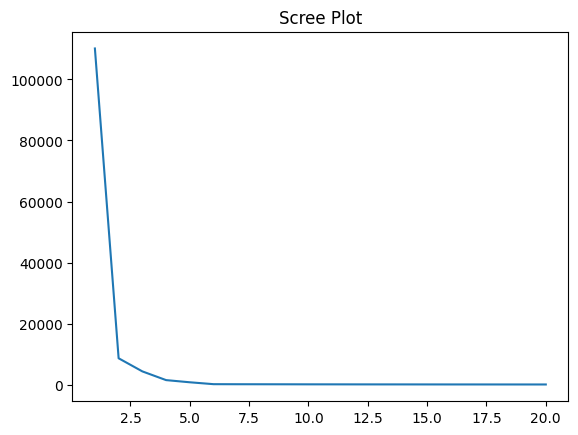

In [7]:
k_bar = 20
k_grid = np.arange(1,k_bar+1)
SSE = np.zeros(k_bar)
for k in range(k_bar):
    model = KMeans(n_clusters=k+1, max_iter=300, n_init = 10, random_state=0)
    model = model.fit(X)
    SSE[k] = model.inertia_

scree_plot = sns.lineplot(x=k_grid, y=SSE).set_title('Scree Plot')

Price                                                           
           count        mean         std   min   25%    50%    75%      max
cluster                                                                    
0        10114.0  177.380660  186.561899  10.0  90.0  147.0  200.0  10000.0
1         8272.0  133.754352   96.434040  20.0  79.0  116.0  170.0   5000.0
2          771.0  133.084306  199.549289  25.0  65.0   99.0  150.0   5000.0
3         2954.0  142.079215   84.303713  22.0  88.0  125.0  175.0   1000.0

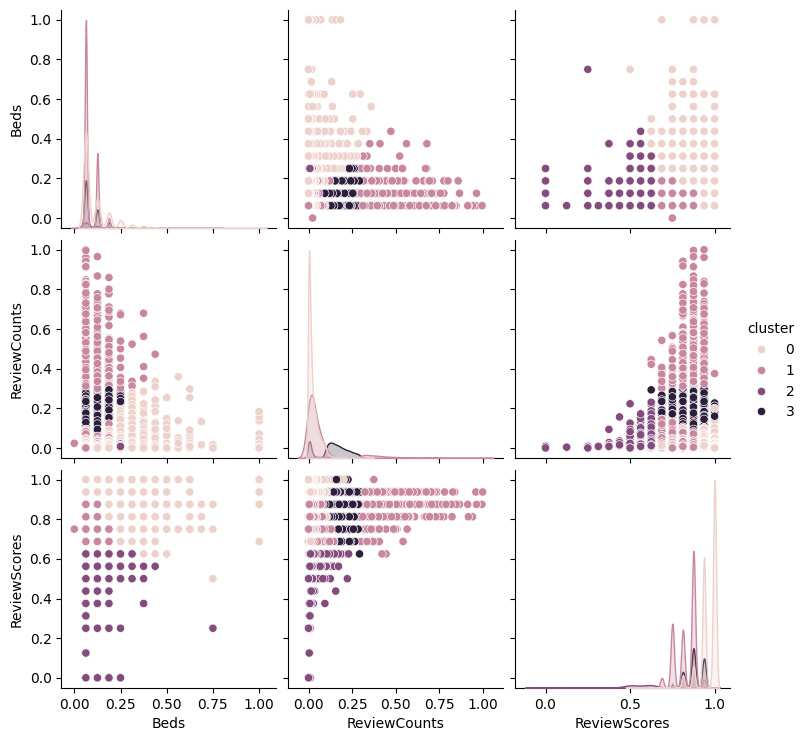

In [9]:
model = KMeans(n_clusters=4, max_iter=300, n_init = 10,  random_state=0)
model = model.fit(X)
X['cluster'] = model.labels_
sns.pairplot(X,hue="cluster")
df1["cluster"] = model.labels_
df1.loc[:,['Price','cluster'] ].groupby('cluster').describe()


**Q2.** This is a question about $k$ means clustering. We want to investigate how adjusting the "noisiness" of the data impacts the quality of the algorithm and the difficulty of picking $k$.

1. Run the code below, which creates four datasets: `df0_125`, `df0_25`, `df0_5`, `df1_0`, and `df2_0`. Each data set is created by increasing the amount of `noise` (standard deviation) around the cluster centers, from `0.125` to `0.25` to `0.5` to `1.0` to `2.0`.

```
import numpy as np
import pandas as pd

def createData(noise,N=50):
    np.random.seed(100) # Set the seed for replicability
    # Generate (x1,x2,g) triples:
    X1 = np.array([np.random.normal(1,noise,N),np.random.normal(1,noise,N)])
    X2 = np.array([np.random.normal(3,noise,N),np.random.normal(2,noise,N)])
    X3 = np.array([np.random.normal(5,noise,N),np.random.normal(3,noise,N)])
    # Concatenate into one data frame
    gdf1 = pd.DataFrame({'x1':X1[0,:],'x2':X1[1,:],'group':'a'})
    gdf2 = pd.DataFrame({'x1':X2[0,:],'x2':X2[1,:],'group':'b'})
    gdf3 = pd.DataFrame({'x1':X3[0,:],'x2':X3[1,:],'group':'c'})
    df = pd.concat([gdf1,gdf2,gdf3],axis=0)
    return df

df0_125 = createData(0.125)
df0_25 = createData(0.25)
df0_5 = createData(0.5)
df1_0 = createData(1.0)
df2_0 = createData(2.0)
```

2. Make scatterplots of the $(X1,X2)$ points by group for each of the datasets. As the `noise` goes up from 0.125 to 2.0, what happens to the visual distinctness of the clusters?
3. Create a scree plot for each of the datasets. Describe how the level of `noise` affects the scree plot (particularly the presence of a clear "elbow") and your ability to definitively select a $k$.
4. Explain the intuition of the elbow, using this numerical simulation as an example.

In [10]:
import numpy as np
import pandas as pd

def createData(noise,N=50):
    np.random.seed(100) # Set the seed for replicability
    # Generate (x1,x2,g) triples:
    X1 = np.array([np.random.normal(1,noise,N),np.random.normal(1,noise,N)])
    X2 = np.array([np.random.normal(3,noise,N),np.random.normal(2,noise,N)])
    X3 = np.array([np.random.normal(5,noise,N),np.random.normal(3,noise,N)])
    # Concatenate into one data frame
    gdf1 = pd.DataFrame({'x1':X1[0,:],'x2':X1[1,:],'group':'a'})
    gdf2 = pd.DataFrame({'x1':X2[0,:],'x2':X2[1,:],'group':'b'})
    gdf3 = pd.DataFrame({'x1':X3[0,:],'x2':X3[1,:],'group':'c'})
    df = pd.concat([gdf1,gdf2,gdf3],axis=0)
    return df

df0_125 = createData(0.125)
df0_25 = createData(0.25)
df0_5 = createData(0.5)
df1_0 = createData(1.0)
df2_0 = createData(2.0)

<Axes: xlabel='x1', ylabel='x2'>

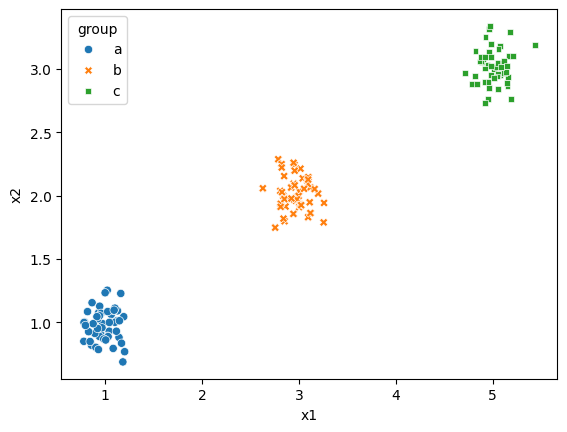

In [11]:
sns.scatterplot(df0_125, x="x1", y="x2",hue="group",style="group")

<Axes: xlabel='x1', ylabel='x2'>

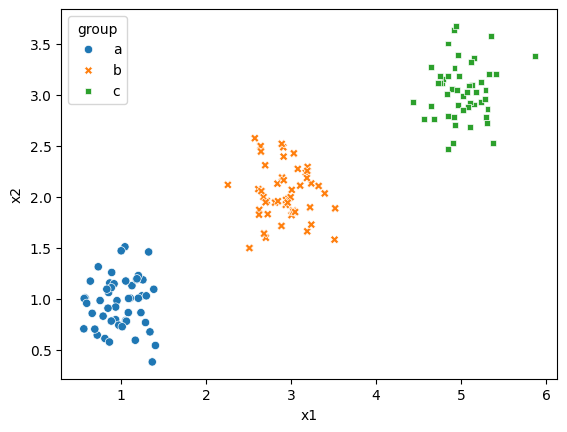

In [12]:
sns.scatterplot(df0_25, x="x1", y="x2",hue="group",style="group")

<Axes: xlabel='x1', ylabel='x2'>

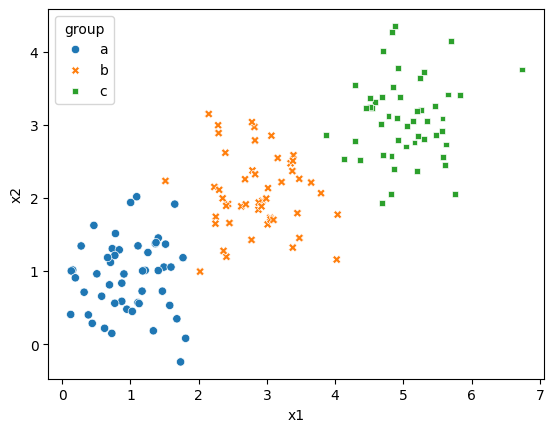

In [13]:
sns.scatterplot(df0_5, x="x1", y="x2",hue="group",style="group")

<Axes: xlabel='x1', ylabel='x2'>

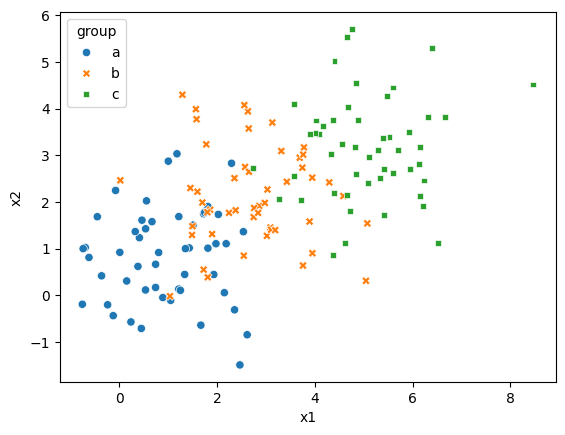

In [14]:
sns.scatterplot(df1_0, x="x1", y="x2",hue="group",style="group")

<Axes: xlabel='x1', ylabel='x2'>

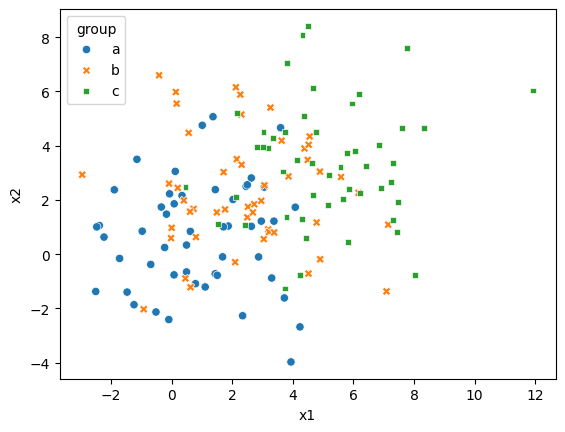

In [15]:
sns.scatterplot(df2_0, x="x1", y="x2",hue="group",style="group")

Q2.2) As the noise increases, it becomes harder to make clear distinctions between the clusters.

In [19]:
import matplotlib.pyplot as plt

def scree(data):
    X = data.loc[ : , ['x1','x2'] ]
    X = X.apply(maxmin)
    k_bar = 15
    k_grid = np.arange(1,k_bar+1)
    SSE = np.zeros(k_bar)
    for k in range(k_bar):
        model = KMeans(n_clusters=k+1, max_iter=300, n_init = 10, random_state=0)
        model = model.fit(X)
        SSE[k] = model.inertia_
    scree_plot, axes = plt.subplots()
    sns.lineplot(x=k_grid, y=SSE).set_title('Scree Plot')
    axes.set_ylim(0, 35)
# copied from solutions

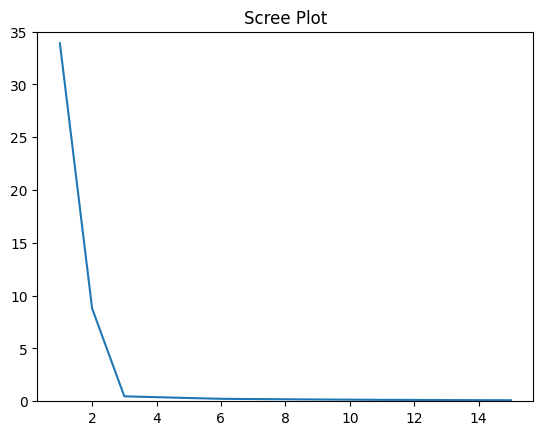

In [20]:
scree(df0_125)

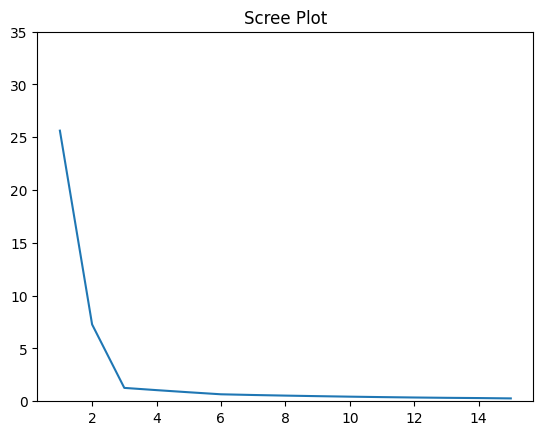

In [21]:
scree(df0_25)

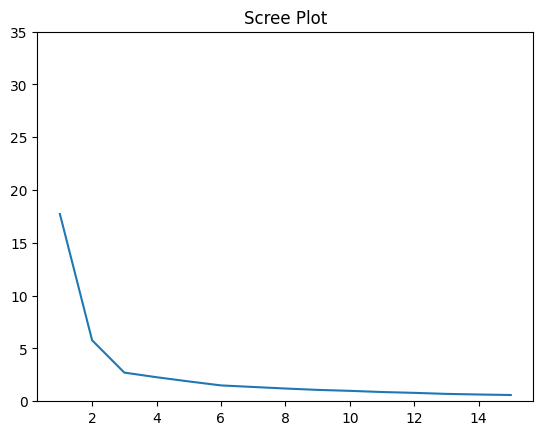

In [22]:
scree(df0_5)

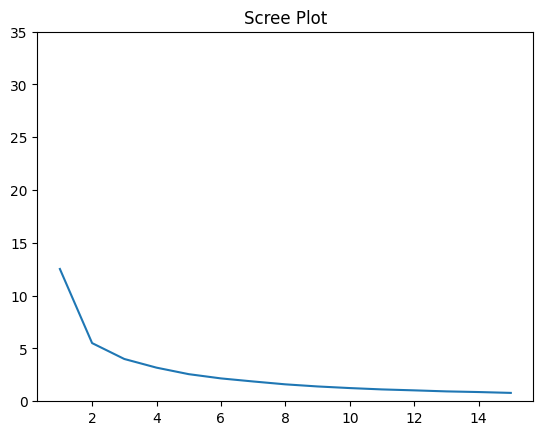

In [23]:
scree(df1_0)

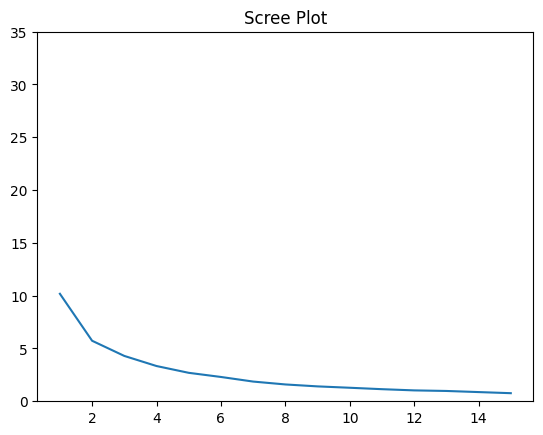

In [24]:
scree(df2_0)

Q2.3) It becomes more difficult to identify a k value as the noise increases. This is apparent in the declining distinct features of the elbow in the scree plots.

Q2.4) The elbow becomes smoother and less distinct whenever the clusters become less distinct. The oppposite also holds true where the elbow becomes more apparent when the clusters become more distinct.

**Q3.** We looked at computer vision with $k$NN in a previous question. Can $k$ means clustering correctly group digits, even if we don't know which symbols are which?

1. To load the data, run the following code in a chunk:
```
from keras.datasets import mnist
df = mnist.load_data('minst.db')
train,test = df
X_train, y_train = train
X_test, y_test = test
```
The `y_test` and `y_train` vectors, for each index `i`, tell you want number is written in the corresponding index in `X_train[i]` and `X_test[i]`. The value of `X_train[i]` and `X_test[i]`, however, is a 28$\times$28 array whose entries contain values between 0 and 256. Each element of the matrix is essentially a "pixel" and the matrix encodes a representation of a number. To visualize this, run the following code to see the first ten numbers:
```
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(edgeitems=30, linewidth=100000)
for i in range(5):
    print(y_test[i],'\n') # Print the label
    print(X_test[i],'\n') # Print the matrix of values
    plt.contourf(np.rot90(X_test[i].transpose())) # Make a contour plot of the matrix values
    plt.show()
```
OK, those are the data: Labels attached to handwritten digits encoded as a matrix.

2. What is the shape of `X_train` and `X_test`? What is the shape of `X_train[i]` and `X_test[i]` for each index `i`? What is the shape of `y_train` and `y_test`?
3. Use Numpy's `.reshape()` method to covert the training and testing data from a matrix into an vector of features. So, `X_test[index].reshape((1,784))` will convert the $index$-th element of `X_test` into a $28\times 28=784$-length row vector of values, rather than a matrix. Turn `X_train` into an $N \times 784$ matrix $X$ that is suitable for scikit-learn's kNN classifier where $N$ is the number of observations and $784=28*28$ (you could use, for example, a `for` loop).
4. Use $k$ means clustering on the reshaped `X_test` data with `k=10`.  
5. Cross tabulate the cluster assignments with the true labels for the test set values. How good is the correspondence? What proportion of digits are clustered correctly? Which digits are the hardest to distinguish from one another? Can $k$MC recover the latent digits 0 to 9, without even knowing what those digits were?
6. If you use a scree plot to determine the number of clusters $k$, does it pick 10 (the true number of digits), or not? If it fails to pick $k=10$, which digits does it tend to combine into the same classification?